<a href="https://colab.research.google.com/github/anshurajak/AIRL-Assignment/blob/main/q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

In [4]:
# Data preprocessing
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),   # random zoom-in/out
    transforms.RandomHorizontalFlip(),                    # flip left-right
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),           # brightness/contrast/saturation/hue
    transforms.RandomRotation(15),                        # small rotations
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),        # CIFAR-10 mean
                         (0.247, 0.243, 0.261)),          # CIFAR-10 std
])

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261)),
])


In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_train)

100%|██████████| 170M/170M [00:04<00:00, 37.2MB/s]


In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **ViT components**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)                          # (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)          # (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)     # prepend CLS
        x = x + self.pos_embed
        return x

In [8]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


In [9]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        # Multi-head self-attention with residual
        attn_out, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_out
        # Feed-forward with residual
        x = x + self.mlp(self.norm2(x))
        return x

In [10]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes,
                 embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(drop_rate)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)     # (B, N+1, E)
        x = self.encoder(x)         # Transformer layers
        x = self.norm(x)
        cls_token = x[:, 0]         # Take CLS token
        cls_token = self.dropout(cls_token)
        return self.head(cls_token)

In [11]:
# Instantiate model
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [13]:
criterion

CrossEntropyLoss()

In [14]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [15]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # Forward pass
        out = model(x)
        loss = criterion(out, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(dim=1) == y).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc


In [16]:
# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(dim=1) == y).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc


In [17]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

best_test_acc = 0
patience = 5  # Number of epochs to wait for improvement before stopping
epochs_no_improve = 0

for epoch in range(EPOCHS):
    # Training step
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)

    # Evaluation step
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Early stopping
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"⏹ Early stopping after {epoch+1} epochs (no improvement in test accuracy).")
            break


Epoch 1/20 Train Loss: 1.6256, Train Acc: 0.4104 Test Loss: 1.3504, Test Acc: 0.5094
Epoch 2/20 Train Loss: 1.2895, Train Acc: 0.5363 Test Loss: 1.2078, Test Acc: 0.5689
Epoch 3/20 Train Loss: 1.1488, Train Acc: 0.5904 Test Loss: 1.1664, Test Acc: 0.5803
Epoch 4/20 Train Loss: 1.0406, Train Acc: 0.6282 Test Loss: 1.1229, Test Acc: 0.5947
Epoch 5/20 Train Loss: 0.9528, Train Acc: 0.6603 Test Loss: 1.0410, Test Acc: 0.6277
Epoch 6/20 Train Loss: 0.8653, Train Acc: 0.6928 Test Loss: 1.0579, Test Acc: 0.6311
Epoch 7/20 Train Loss: 0.7834, Train Acc: 0.7222 Test Loss: 1.0602, Test Acc: 0.6299
Epoch 8/20 Train Loss: 0.7082, Train Acc: 0.7495 Test Loss: 1.0292, Test Acc: 0.6455
Epoch 9/20 Train Loss: 0.6272, Train Acc: 0.7787 Test Loss: 1.0748, Test Acc: 0.6446
Epoch 10/20 Train Loss: 0.5572, Train Acc: 0.8009 Test Loss: 1.1154, Test Acc: 0.6457
Epoch 11/20 Train Loss: 0.4816, Train Acc: 0.8291 Test Loss: 1.1473, Test Acc: 0.6455
Epoch 12/20 Train Loss: 0.4312, Train Acc: 0.8456 Test Loss: 1.

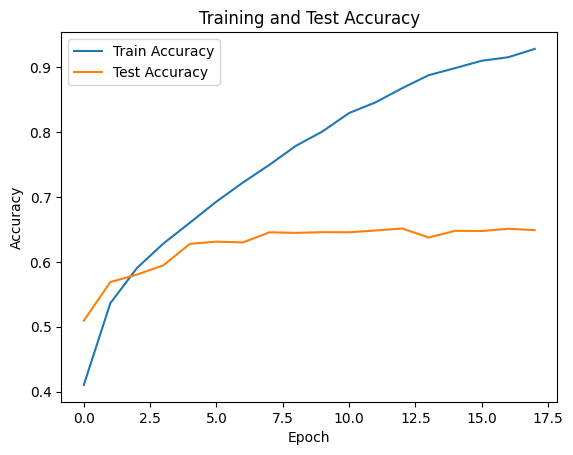

In [18]:
# Plot accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()

In [19]:
import random

In [20]:
test_dataset[0][0].shape

torch.Size([3, 32, 32])

In [21]:
test_dataset[0][0].unsqueeze(dim=0).shape

torch.Size([1, 3, 32, 32])

In [22]:
def predict_and_plot_grid(model, dataset, classes, grid_size = 3):
  model.eval()
  fig, axes = plt.subplots(grid_size, grid_size, figsize = (9,9)) # Corrected plt.subplot to plt.subplots
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0, len(dataset) - 1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)

      with torch.no_grad(): # Corrected torch.interence_nodel() to torch.no_grad()
        output = model(input_tensor)
        _, predicted = torch.max(output.data, 1)

      # Normalize image for display
      img = img / 2 + 0.5
      npimg = img.cpu().numpy()

      # Corrected transpose for image display
      axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))

      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = 'g'
      else:
        color = "r" # Corrected variable name from c to color

      # Corrected f-string syntax
      axes[i, j].set_title(f"Truth: {classes[true_label]}\nPredicted: {classes[predicted.item()]}", fontsize = 10, color = color)
      axes[i, j].axis('off')
  plt.tight_layout()
  plt.show()

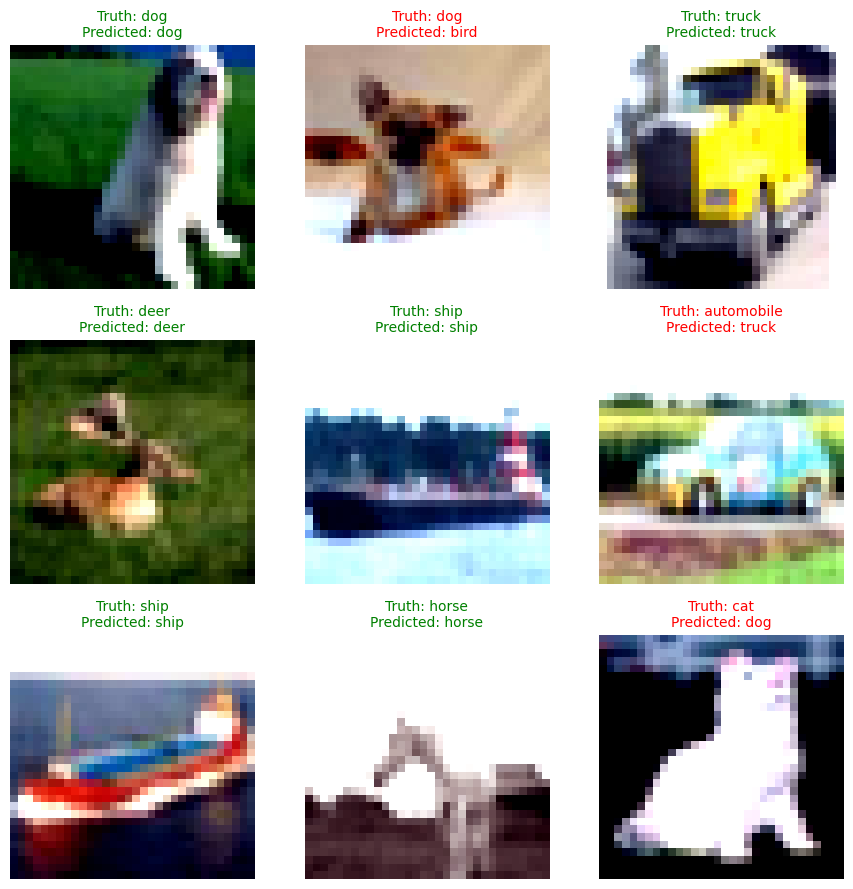

In [23]:
predict_and_plot_grid(model, test_dataset, classes= train_dataset.classes, grid_size=3)